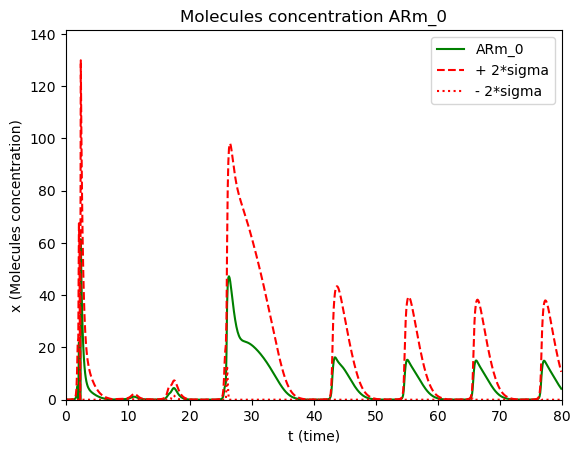

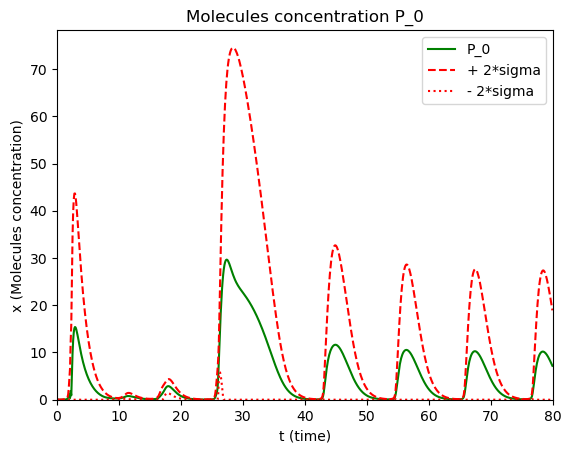

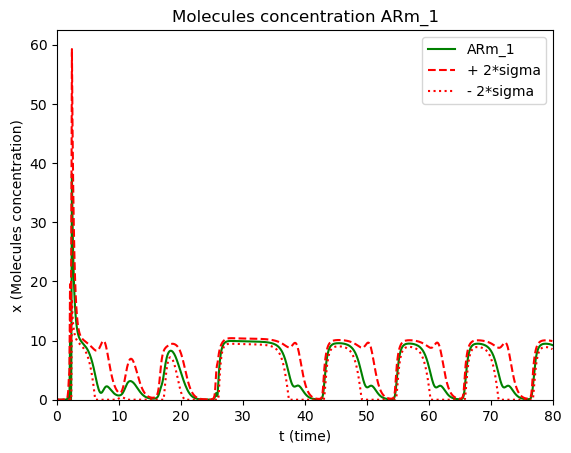

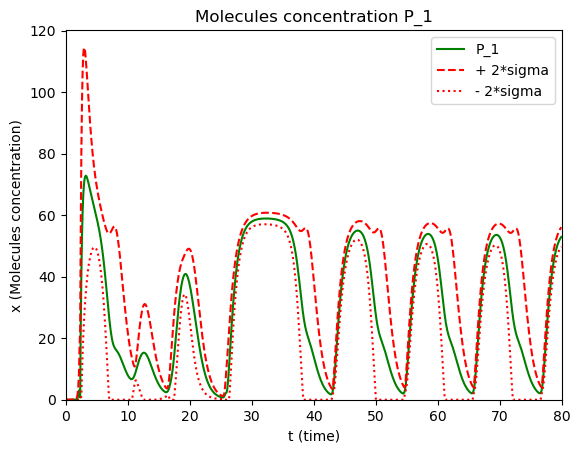

In [1]:
'Redes geneticas estocasticas' 'reloj ativador represor'
'funcion de hill determinista'

#En este programa se implementa el agoritmo de Gillespie para reacciones bioquimicas,
#especificamente para una red de transcripcion/traduccion.

# se importan las librerias que seran usadas
import numpy as np
import math 
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numdifftools as nd 

#para implementar el algoritmo son necesarias algunas cantidades y definir algunos parametros
#condiciones iniciales de las variables involucradas y el tiempo

A=np.array([ [0,-1],
             [-1,0],]) # matriz de conexiones

t0=0.0 #tiempo inicial
tf= 80 # tiempo final
N=2  #coeficientes de de Hill para cada uno de los nodos
K=[1,1,1] # constantes de Michelson para cada nodo
n1= len(A[0]) #numero de nodos
n2= 2 #numero de elementos en cada nodo
Omega=180 # tamaño del sistema
t1=0.01

#condiciones iniciales para cada nodo
x=[0,0,0,0] #vector de condiciones iniciales [ARm0, P0]
                                  #  [ARm2, P2]
n=len(x)
#parametros, los vectores para cada uno de los nodos 
p1=1
p2=5
k1=[p2,p1,1,p1]  #[sintesis o degradacion de ARm a travez de Hill, degradacion ARm, sintesis proteina, degradacion proteina]
 
#contruimos la matriz estequiometrica para cada nodo 'evitar editar a partir de esta linea'
S= [[1,-1,0, 0],
    [ 0,0 ,1,-1],]

#construimos la matriz estequimetrica del sistema
def ST(S,n):
    l1=np.zeros([2,4])
    S1=S
    l2=l1
    l3=S
    for i in range(n-1):
        S1= np.append(S1, l2, axis = 1)
        l3=np.append(l1,l3, axis=1)
        S1= np.r_[S1,l3]
        l2= np.r_[l2,l1]
    return S1

S=ST(S,n1)
n3=len(S[0]) #numero de entradas de S

#varianza inicial
sigma_0=np.zeros(n*n)

def H_d1(x,n,K): #funcion de hill determinista
    return (x)**n/(K + (x)**n)

def H_d2(x,y,n,K): #funcion de hill determinista
    return ((x)**n+ 0.0004)/(K + (y)**n+ (x)**n)

#definimos unas funciones
def Gradvector(f,variables):  #calcula el hessiano de un vector
    l1=len(f)
    G=np.zeros([l1,n])
    for i in range(l1):
         G[i]= nd.Gradient(f[i])(variables)
    return G

def Hessvector(f,variables):  #calcula el hessiano de un vector
    l1=len(f)
    H=np.zeros([l1,n,n])
    for i in range(l1):
         H[i]= nd.Hessian(f[i])(variables)
    return H

def sumasAB(A,B): #funcion para sumar entrada por entrada cada matriz
    l1=len(A)
    l2=0
    for i in range(l1):
        for j in range(l1):
            l2 +=  A[i][j]*B[i][j]
    return l2

def contraer1(A,B): #contrae matrices
    l1=np.zeros([n,n,n])
    for i in range(n):
        for j in range(n3):
            l1[i,:] += A[i,j]*B[j,:,:]
    return l1

def contraer2(A,B): #contrae matriz y tensor
    l1=np.zeros([n,n])
    for i in range(n):
        for j in range(n3):
            l1[i,:] += A[i,j]*B[j,:]
    return l1

def contraer3(S1,S2): #construye entradas
    l1=np.zeros(n3)
    for i in range(n3):
        l1[i]=S1[i]*S2[i]
    return l1

def contraer4(S1,T): #contrae vector y tensor
    l1=np.zeros([n,n])
    for i in range(n3):
        l1[:] += S1[i]*T[i,:,:]
    return l1

def evaluarvector(vec,variables): #evaluar un vector de función lamda
    l1=len(vec)
    l2=np.zeros(l1)
    for i in range(l1):
        l2[i]=vec[i](variables)
    return l2

def rehacer(A): #restructura matriz
    l1=np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            l1[i,j]=A[i+1,j]
    return l1

x=np.r_[x,sigma_0] # construimos un vector con x y sigma iniciales

# funcion para construir la ecuacion diferencial
def Sistema(State,t):
        
    Y  = State 

    #restructuramos el vector de entrada    
    Y=Y.reshape(n+1,n)

    #escribimos los vectores de propension            
    ni = [lambda x1: 250*(H_d2(x1[1],x1[3],2,1)), lambda x1: 3*x1[0], lambda x1: 1*x1[0], lambda x1: 1*x1[1], 
          lambda x1: 30*(H_d1(x1[1],2,1)), lambda x1: 3*x1[2], lambda x1: 6*x1[2], lambda x1: 1*x1[3]]

       
    hessni=Hessvector(ni,Y[0])   #hessiano de ni+, se omite el otro ya que es cero
    T1=contraer1(S,hessni) #contraemos el hessiano con la matriz estequiometrica

    gradni=Gradvector(ni,Y[0]) #gradiende de ni+
    T2=contraer2(S,gradni) #contraemos el gradiente de ni+ con la matriz estequiometrica

    #evaluar los vectores ni+-
    ni=evaluarvector(ni,Y[0]) 
    #ni_=evaluarvector(ni_,Y[0])

    #se crean los terminos de derivada temporal
    Y_dot=np.zeros(n)
    sigma_dot= np.zeros([n,n])
    
    #construimos a sigma
    sigma=rehacer(Y)

    #evaluamos las derivadas temporales
    for i in range(n):
        Y_dot[i]= np.dot(S[i],ni)  + sumasAB(sigma,T1[i,:,:])

    for i in range(n):
        for j in range(i,n):
            sigma_dot[i,j]=sigma_dot[j,i]= (np.dot(contraer3(S[i],S[j]),ni/Omega) 
                                           + np.dot(sigma[i],T2[j]) + np.dot(sigma[j],T2[i])
                                           + sumasAB(sigma, contraer4(contraer3(S[i],S[j]),hessni))/(2*Omega))
                                                       
    #rescribimos a sigma como vector
    sigma_dot=sigma_dot.reshape(1,n*n)
    
    #escribimos a Y_dot y sigma_dot como un vector
    l4=np.r_[Y_dot,sigma_dot[0]]

    return l4

#A resolver
t = np.arange(0,tf,0.1) #construimos el rango de t
State = odeint(Sistema,x,t)
Y = State.T

#funciones para poder graficar
def raiz(vec): #funcion para sacar raiz a las entradas de un vector
    l1=len(vec)
    for i in range(l1):
        if vec[i]>=0:
            vec[i]=math.sqrt(vec[i])
        else:
            vec[i]=0
    return vec

def heav(vec): #funcion que devuelve solo valores mayores que cero
    l1=len(vec)
    for i in range(l1):
        if vec[i]>=0:
            vec[i]=vec[i]                 
        else:
           vec[i]=0  
    return vec

#sacamos la raiz al vector para encontrar la desviacion
Y[4]= raiz(Y[4])
Y[9]= raiz(Y[9])
Y[14]= raiz(Y[14])
Y[19]= raiz(Y[19])

eta11= Y[4]
eta12=Y[9]
eta13=Y[14]
eta14=Y[19]



#promedios menos 2*sigma
ru=2
Ysigma1=heav(Y[0]-ru*Y[4])
Ysigma2=heav(Y[1]-ru*Y[9])
Ysigma3=heav(Y[2]-ru*Y[14])
Ysigma4=heav(Y[3]-ru*Y[19])

# A graficar
fig1 = plt.figure(1) 
plt.title( 'Molecules concentration ARm_0' )
plt.plot(t,Y[0],color='green', label= 'ARm_0')
plt.plot(t,(Y[0]+ru*Y[4]),'--', color="red" , label= '+ 2*sigma')
plt.plot(t,Ysigma1,':', color="red", label= '- 2*sigma')
plt.xlabel("t (time)")
plt.ylabel("x (Molecules concentration)")
plt.xlim(0, tf)
plt.ylim(0)
plt.legend()

fig2 = plt.figure(2)
plt.title( 'Molecules concentration P_0' )
plt.plot(t,Y[1],color='green', label='P_0')
plt.plot(t,(Y[1]+ru*Y[9]),'--', color="red", label= '+ 2*sigma')
plt.plot(t,Ysigma2,':', color="red", label= '- 2*sigma')
plt.xlabel("t (time)")
plt.ylabel("x (Molecules concentration)")
plt.xlim(0, tf)
plt.ylim(0)
plt.legend()

fig3 = plt.figure(3)
plt.title( 'Molecules concentration ARm_1' )
plt.plot(t,Y[2],color='green', label='ARm_1')
plt.plot(t,(Y[2]+ru*Y[14]),'--', color="red", label= '+ 2*sigma')
plt.plot(t, Ysigma3, ':', color="red", label= '- 2*sigma')
plt.xlabel("t (time)")
plt.ylabel("x (Molecules concentration)")
plt.xlim(0, tf)
plt.ylim(0)
plt.legend()

fig4 = plt.figure(4)
plt.title( 'Molecules concentration P_1' )
plt.plot(t,Y[3],color='green', label='P_1')
plt.plot(t,(Y[3]+ru*Y[19]),'--', color="red", label= '+ 2*sigma')
plt.plot(t,Ysigma4,':', color="red", label= '- 2*sigma')
plt.xlabel("t (time)")
plt.ylabel("x (Molecules concentration)")
plt.xlim(0, tf)
plt.ylim(0)
plt.legend()

plt.show()

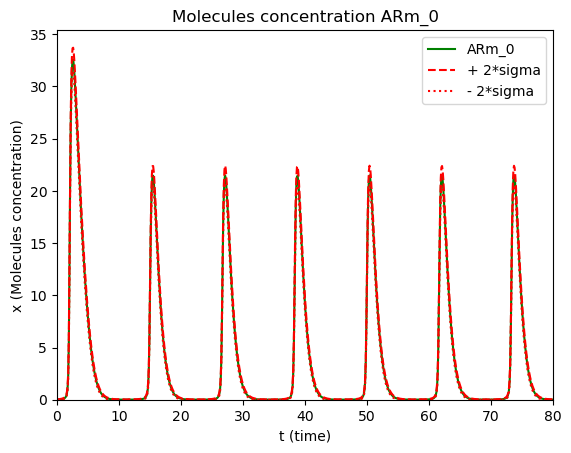

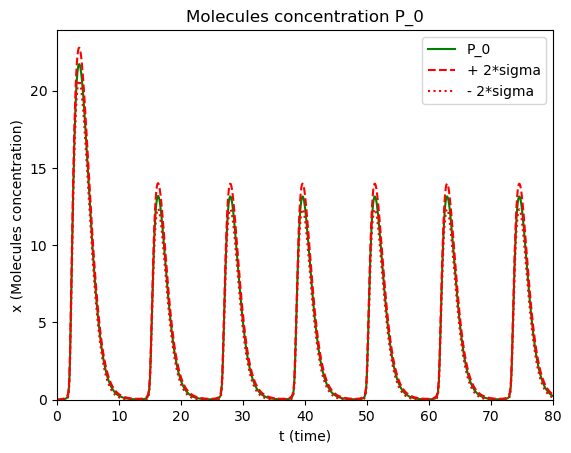

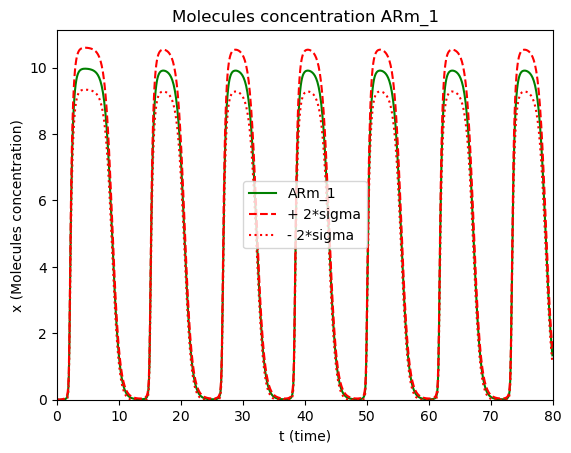

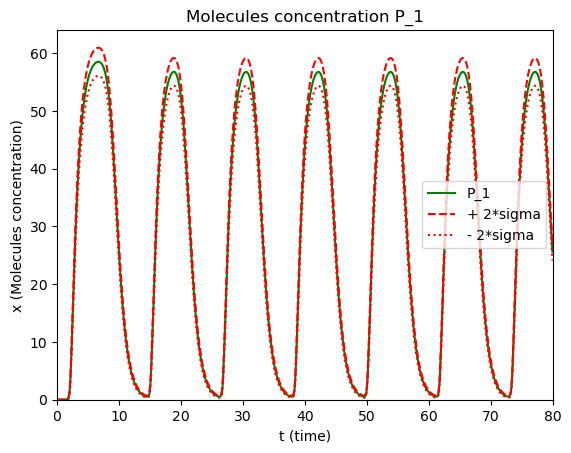

In [2]:
'Redes geneticas estocasticas' 'reloj ativador represor'
'funcion de hill con correcciones estocasticas'

#En este programa se implementa el agoritmo de Gillespie para reacciones bioquimicas,
#especificamente para una red de transcripcion/traduccion.

# se importan las librerias que seran usadas
import numpy as np
import math 
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numdifftools as nd 

#para implementar el algoritmo son necesarias algunas cantidades y definir algunos parametros
#condiciones iniciales de las variables involucradas y el tiempo

A=np.array([ [0,-1],
             [-1,0],]) # matriz de conexiones

t0=0.0 #tiempo inicial
tf= 80 # tiempo final
N=2  #coeficientes de de Hill para cada uno de los nodos
K=[1,1,1] # constantes de Michelson para cada nodo
n1= len(A[0]) #numero de nodos
n2= 2 #numero de elementos en cada nodo
Omega=100 # tamaño del sistema
t1=0.01

#condiciones iniciales para cada nodo
x=[0,0,0,0] #vector de condiciones iniciales [ARm0, P0]
                                  #  [ARm2, P2]
n=len(x)
#parametros, los vectores para cada uno de los nodos 
p1=1
p2=5
k1=[p2,p1,1,p1]  #[sintesis o degradacion de ARm a travez de Hill, degradacion ARm, sintesis proteina, degradacion proteina]
 
#contruimos la matriz estequiometrica para cada nodo 'evitar editar a partir de esta linea'
S= [[1,-1,0, 0],
    [ 0,0 ,1,-1],]

#construimos la matriz estequimetrica del sistema
def ST(S,n):
    l1=np.zeros([2,4])
    S1=S
    l2=l1
    l3=S
    for i in range(n-1):
        S1= np.append(S1, l2, axis = 1)
        l3=np.append(l1,l3, axis=1)
        S1= np.r_[S1,l3]
        l2= np.r_[l2,l1]
    return S1

S=ST(S,n1)
n3=len(S[0]) #numero de entradas de S

#varianza inicial
sigma_0=np.zeros(n*n)

def H_d1(x,z,n,K): #funcion de hill determinista
    return ((x)**n+ + z*n*(n-1)*((x)**(n-2)))/(K + (x)**n+ + z*n*(n-1)*((x)**(n-2)))

def H_d2(x,y,z1,z2,n,K): #funcion de hill determinista
    return ((x)**n+ + z1*n*(n-1)*((x)**(n-2))+ 0.0004)/(K + (y)**n+ (x)**n + z1*n*(n-1)*((x)**(n-2)) + z2*n*(n-1)*((y)**(n-2)))

#definimos unas funciones
def Gradvector(f,variables):  #calcula el hessiano de un vector
    l1=len(f)
    G=np.zeros([l1,n])
    for i in range(l1):
         G[i]= nd.Gradient(f[i])(variables)
    return G

def Hessvector(f,variables):  #calcula el hessiano de un vector
    l1=len(f)
    H=np.zeros([l1,n,n])
    for i in range(l1):
         H[i]= nd.Hessian(f[i])(variables)
    return H

def sumasAB(A,B): #funcion para sumar entrada por entrada cada matriz
    l1=len(A)
    l2=0
    for i in range(l1):
        for j in range(l1):
            l2 +=  A[i][j]*B[i][j]
    return l2

def contraer1(A,B): #contrae matrices
    l1=np.zeros([n,n,n])
    for i in range(n):
        for j in range(n3):
            l1[i,:] += A[i,j]*B[j,:,:]
    return l1

def contraer2(A,B): #contrae matriz y tensor
    l1=np.zeros([n,n])
    for i in range(n):
        for j in range(n3):
            l1[i,:] += A[i,j]*B[j,:]
    return l1

def contraer3(S1,S2): #construye entradas
    l1=np.zeros(n3)
    for i in range(n3):
        l1[i]=S1[i]*S2[i]
    return l1

def contraer4(S1,T): #contrae vector y tensor
    l1=np.zeros([n,n])
    for i in range(n3):
        l1[:] += S1[i]*T[i,:,:]
    return l1

def evaluarvector(vec,variables): #evaluar un vector de función lamda
    l1=len(vec)
    l2=np.zeros(l1)
    for i in range(l1):
        l2[i]=vec[i](variables)
    return l2

def rehacer(A): #restructura matriz
    l1=np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            l1[i,j]=A[i+1,j]
    return l1

x=np.r_[x,sigma_0] # construimos un vector con x y sigma iniciales

# funcion para construir la ecuacion diferencial
def Sistema(State,t):
        
    Y  = State 

    #restructuramos el vector de entrada    
    Y=Y.reshape(n+1,n)

    #construimos a sigma
    sigma=rehacer(Y)

    #escribimos los vectores de propension            
    ni = [lambda x1: 250*(H_d2(Y[0,1],Y[0,3],sigma[1,1], sigma[3,3],2,1)), lambda x1: 3*x1[0], lambda x1: 1*x1[0], lambda x1: 1*x1[1], 
          lambda x1: 30*(H_d1(Y[0,1], sigma[1,1],2,1)), lambda x1: 3*x1[2], lambda x1: 6*x1[2], lambda x1: 1*x1[3]]

    #hessni=Hessvector(ni,Y[0])   #hessiano de ni+, se omite el otro ya que es cero
    #T1=contraer1(S,hessni) #contraemos el hessiano con la matriz estequiometrica

    gradni=Gradvector(ni,Y[0]) #gradiende de ni+
    T2=contraer2(S,gradni) #contraemos el gradiente de ni+ con la matriz estequiometrica

    #evaluar los vectores ni+-
    ni=evaluarvector(ni,Y[0]) 
    #ni_=evaluarvector(ni_,Y[0])

    #se crean los terminos de derivada temporal
    Y_dot=np.zeros(n)
    sigma_dot= np.zeros([n,n])
    

    #evaluamos las derivadas temporales
    for i in range(n):
        Y_dot[i]= np.dot(S[i],ni)  #+ sumasAB(sigma,T1[i,:,:])

    for i in range(n):
        for j in range(i,n):
            sigma_dot[i,j]=sigma_dot[j,i]= (np.dot(contraer3(S[i],S[j]),ni/Omega) 
                                           + np.dot(sigma[i],T2[j]) + np.dot(sigma[j],T2[i])
                                           )#+ sumasAB(sigma, contraer4(contraer3(S[i],S[j]),hessni))/(2*Omega))
                                                       
    #rescribimos a sigma como vector
    sigma_dot=sigma_dot.reshape(1,n*n)
    
    #escribimos a Y_dot y sigma_dot como un vector
    l4=np.r_[Y_dot,sigma_dot[0]]

    return l4

#A resolver
t = np.arange(0,tf,0.1) #construimos el rango de t
State = odeint(Sistema,x,t)
Y = State.T

#funciones para poder graficar
def raiz(vec): #funcion para sacar raiz a las entradas de un vector
    l1=len(vec)
    for i in range(l1):
        if vec[i]>=0:
            vec[i]=math.sqrt(vec[i])
        else:
            vec[i]=0
    return vec

def heav(vec): #funcion que devuelve solo valores mayores que cero
    l1=len(vec)
    for i in range(l1):
        if vec[i]>=0:
            vec[i]=vec[i]                 
        else:
           vec[i]=0  
    return vec

#sacamos la raiz al vector para encontrar la desviacion
Y[4]= raiz(Y[4])
Y[9]= raiz(Y[9])
Y[14]= raiz(Y[14])
Y[19]= raiz(Y[19])

eta21= Y[4]
eta22=Y[9]
eta23=Y[14]
eta24=Y[19]

eta31= raiz(Y[0]/Omega)
eta32=raiz(Y[1]/Omega)
eta33=raiz(Y[2]/Omega)
eta34=raiz(Y[3]/Omega)

#promedios menos 2*sigma
ru=2
Ysigma1=heav(Y[0]-ru*Y[4])
Ysigma2=heav(Y[1]-ru*Y[9])
Ysigma3=heav(Y[2]-ru*Y[14])
Ysigma4=heav(Y[3]-ru*Y[19])

# A graficar
fig1 = plt.figure(1) 
plt.title( 'Molecules concentration ARm_0' )
plt.plot(t,Y[0],color='green', label= 'ARm_0')
plt.plot(t,(Y[0]+ru*Y[4]),'--', color="red" , label= '+ 2*sigma')
plt.plot(t,Ysigma1,':', color="red", label= '- 2*sigma')
plt.xlabel("t (time)")
plt.ylabel("x (Molecules concentration)")
plt.xlim(0, tf)
plt.ylim(0)
plt.legend()

fig2 = plt.figure(2)
plt.title( 'Molecules concentration P_0' )
plt.plot(t,Y[1],color='green', label='P_0')
plt.plot(t,(Y[1]+ru*Y[9]),'--', color="red", label= '+ 2*sigma')
plt.plot(t,Ysigma2,':', color="red", label= '- 2*sigma')
plt.xlabel("t (time)")
plt.ylabel("x (Molecules concentration)")
plt.xlim(0, tf)
plt.ylim(0)
plt.legend()

fig3 = plt.figure(3)
plt.title( 'Molecules concentration ARm_1' )
plt.plot(t,Y[2],color='green', label='ARm_1')
plt.plot(t,(Y[2]+ru*Y[14]),'--', color="red", label= '+ 2*sigma')
plt.plot(t, Ysigma3, ':', color="red", label= '- 2*sigma')
plt.xlabel("t (time)")
plt.ylabel("x (Molecules concentration)")
plt.xlim(0, tf)
plt.ylim(0)
plt.legend()

fig4 = plt.figure(4)
plt.title( 'Molecules concentration P_1' )
plt.plot(t,Y[3],color='green', label='P_1')
plt.plot(t,(Y[3]+ru*Y[19]),'--', color="red", label= '+ 2*sigma')
plt.plot(t,Ysigma4,':', color="red", label= '- 2*sigma')
plt.xlabel("t (time)")
plt.ylabel("x (Molecules concentration)")
plt.xlim(0, tf)
plt.ylim(0)
plt.legend()

plt.show()

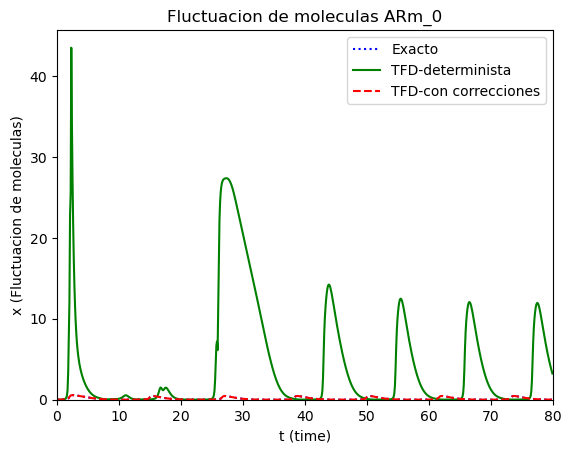

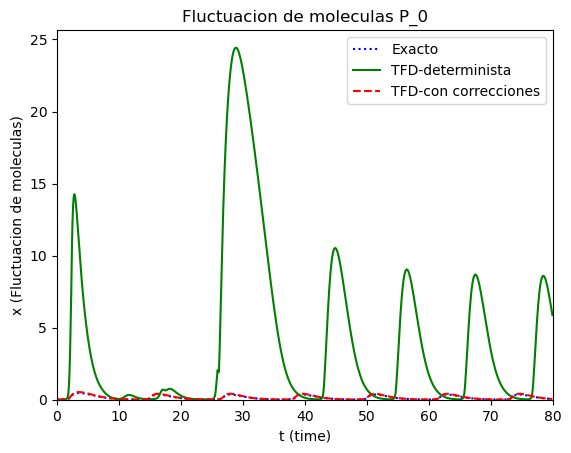

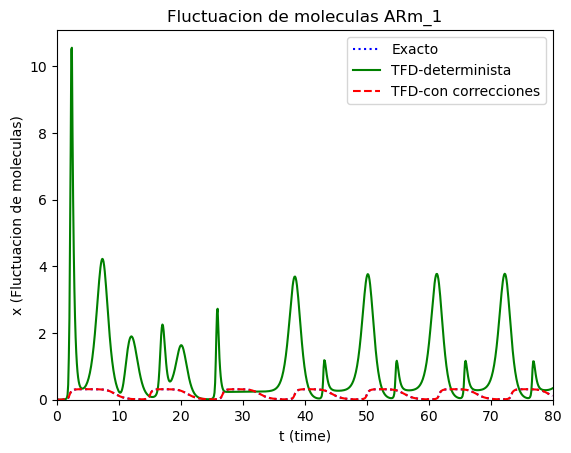

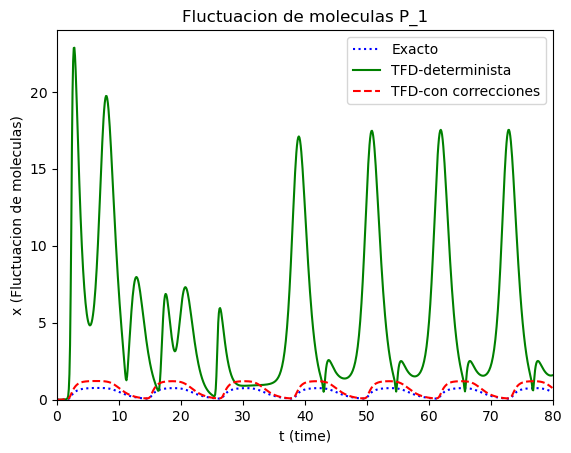

In [7]:
fig7 = plt.figure(6)
plt.title( 'Fluctuacion de moleculas ARm_0' )
plt.plot(t,eta31,':', color="blue", label= 'Exacto')
plt.plot(t,eta11,color='green', label='TFD-determinista')
plt.plot(t,eta21,'--', color="red", label= 'TFD-con correcciones')
plt.xlabel("t (time)")
plt.ylabel("x (Fluctuacion de moleculas)")
plt.xlim(0, tf)
plt.ylim(0)
plt.legend()


fig8 = plt.figure(7)
plt.title( 'Fluctuacion de moleculas P_0' )
plt.plot(t,eta32,':', color="blue", label= 'Exacto')
plt.plot(t,eta12,color='green', label='TFD-determinista')
plt.plot(t,eta22,'--', color="red", label= 'TFD-con correcciones')
plt.xlabel("t (time)")
plt.ylabel("x (Fluctuacion de moleculas)")
plt.xlim(0, tf)
plt.ylim(0)
plt.legend()

fig9 = plt.figure(8)
plt.title( 'Fluctuacion de moleculas ARm_1' )
plt.plot(t,eta33,':', color="blue", label= 'Exacto')
plt.plot(t,eta13,color='green', label='TFD-determinista')
plt.plot(t,eta23,'--', color="red", label= 'TFD-con correcciones')
plt.xlabel("t (time)")
plt.ylabel("x (Fluctuacion de moleculas)")
plt.xlim(0, tf)
plt.ylim(0)
plt.legend()

fig9 = plt.figure(9)
plt.title( 'Fluctuacion de moleculas P_1' )
plt.plot(t,eta34,':', color="blue", label= 'Exacto')
plt.plot(t,eta14,color='green', label='TFD-determinista')
plt.plot(t,eta24,'--', color="red", label= 'TFD-con correcciones')
plt.xlabel("t (time)")
plt.ylabel("x (Fluctuacion de moleculas)")
plt.xlim(0, tf)
plt.ylim(0)
plt.legend()

plt.show()